### 1. Importing Libraries

In [94]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

### 2. Loading the Dataset

In [95]:
df = pd.read_csv("MasterClass-FinTech01-Data.csv")

### 3. Initial Data Inspection

In [96]:
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nFirst 5 rows of the dataset:")
print(df.head())

Dataset shape: (1500, 15)

Column names: ['monthly_income', 'avg_monthly_spend', 'credit_limit', 'num_transactions', 'account_tenure_months', 'cash_withdraw_ratio', 'late_payment_count', 'age', 'region_risk_score', 'marketing_score', 'app_login_count', 'employment_type', 'debt_to_income', 'payment_delay_ratio', 'repayment_issue']

Data types:
 monthly_income           float64
avg_monthly_spend        float64
credit_limit             float64
num_transactions           int64
account_tenure_months      int64
cash_withdraw_ratio      float64
late_payment_count         int64
age                        int64
region_risk_score        float64
marketing_score          float64
app_login_count            int64
employment_type           object
debt_to_income           float64
payment_delay_ratio      float64
repayment_issue            int64
dtype: object

First 5 rows of the dataset:
   monthly_income  avg_monthly_spend  credit_limit  num_transactions  \
0    26867.849400       18963.331725  13797

### 4. Outlier Detection on the Entire Dataset

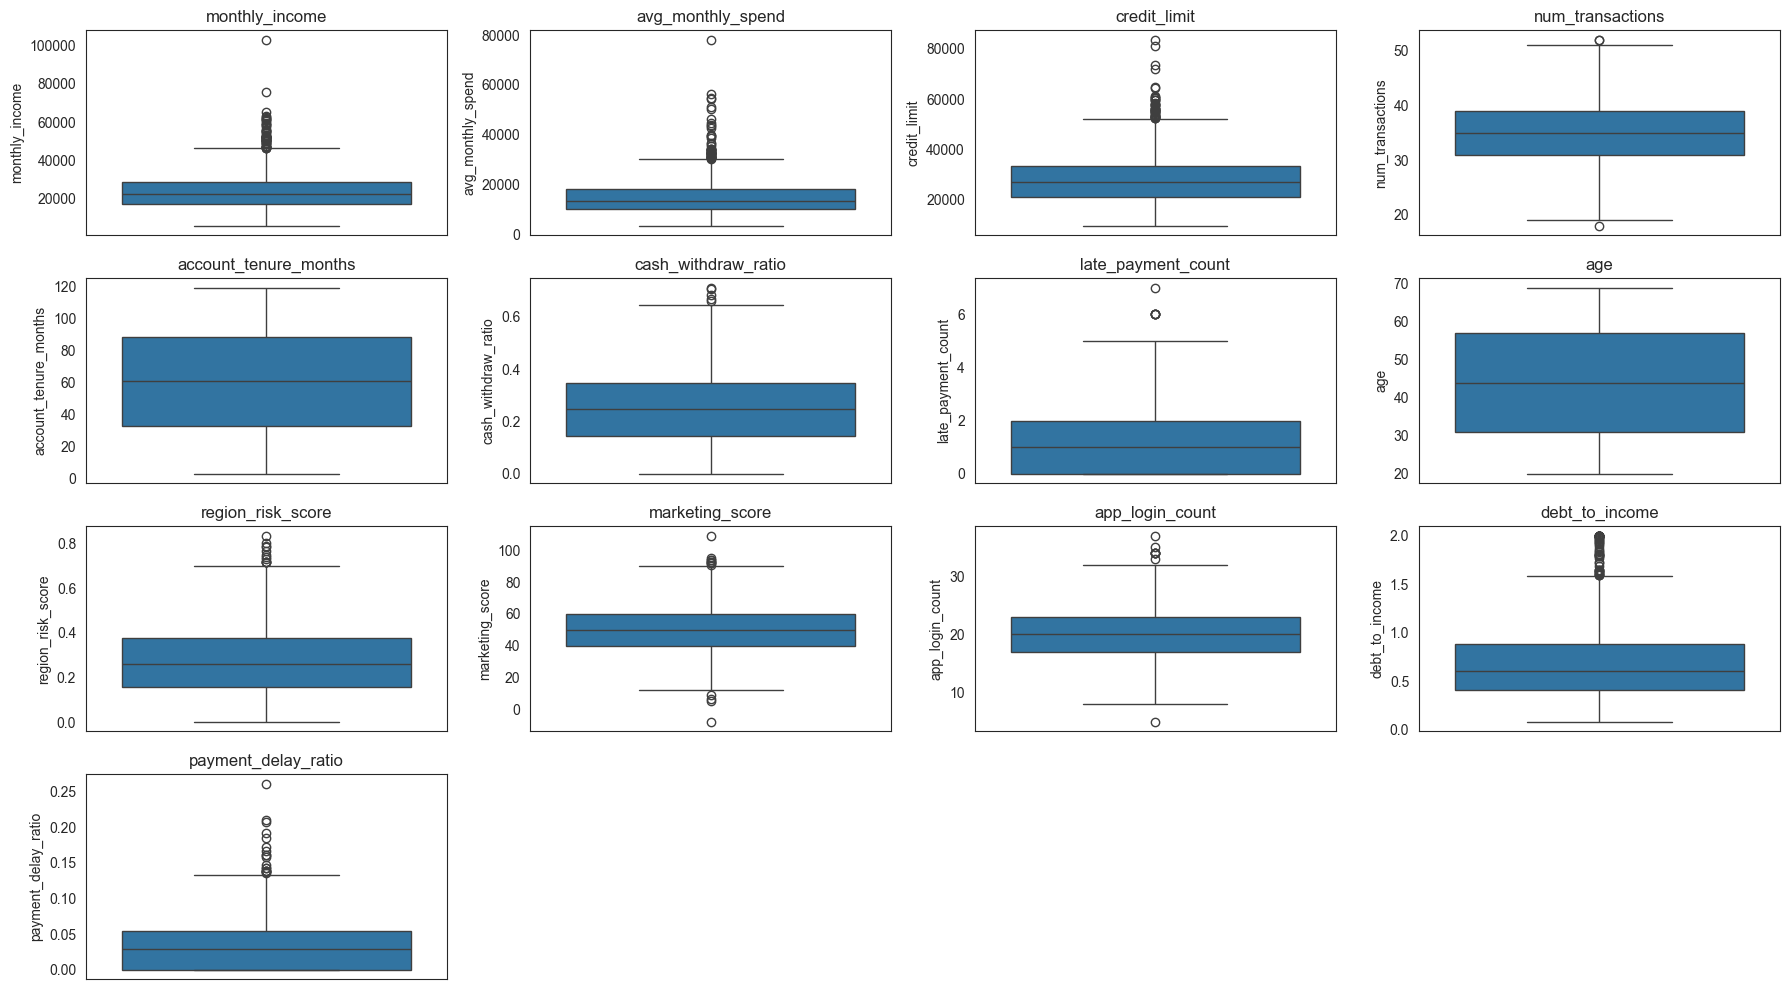

                  feature  outlier_count  outlier_percentage
11         debt_to_income             66                4.40
0          monthly_income             54                3.60
1       avg_monthly_spend             48                3.20
2            credit_limit             41                2.73
12    payment_delay_ratio             19                1.27
9         marketing_score             13                0.87
8       region_risk_score             12                0.80
10        app_login_count              9                0.60
6      late_payment_count              6                0.40
5     cash_withdraw_ratio              5                0.33
3        num_transactions              3                0.20
4   account_tenure_months              0                0.00
7                     age              0                0.00


In [97]:
target_column = "repayment_issue"

numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_features = [col for col in numeric_features if col != target_column]

outlier_summary = []

plt.figure(figsize=(18, 10))
for i, col in enumerate(numeric_features):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_ratio = outlier_count / len(df) * 100

    outlier_summary.append({
        "feature": col,
        "outlier_count": outlier_count,
        "outlier_percentage": round(outlier_ratio, 2)
    })

plt.tight_layout()
plt.show()

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.sort_values(by="outlier_percentage", ascending=False))

### 5. Checking for Missing Values

In [98]:
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
monthly_income           111
avg_monthly_spend          0
credit_limit               0
num_transactions           0
account_tenure_months      0
cash_withdraw_ratio        0
late_payment_count         0
age                        0
region_risk_score          0
marketing_score            0
app_login_count            0
employment_type          109
debt_to_income             0
payment_delay_ratio        0
repayment_issue            0
dtype: int64


### 6. Exploring Target Variable Distribution 
(`repayment_issue`)


Number of samples per class:
repayment_issue
1    1339
0     161
Name: count, dtype: int64


C:\Users\Faezeh\AppData\Local\Temp\ipykernel_8312\1758820362.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='repayment_issue', data=df, palette="viridis")


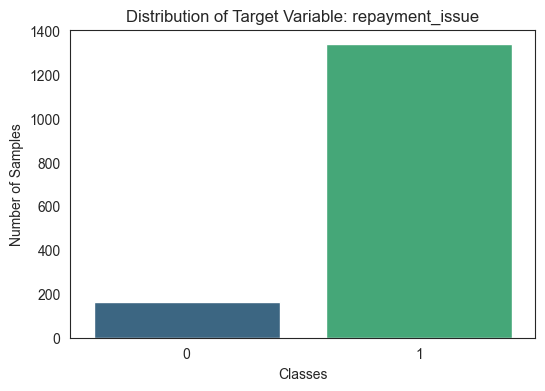

In [99]:
print("\nNumber of samples per class:")
print(df['repayment_issue'].value_counts())

sns.set_style("white")
plt.figure(figsize=(6, 4))
sns.countplot(x='repayment_issue', data=df, palette="viridis")
plt.title("Distribution of Target Variable: repayment_issue")
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.show()

### 7. Splitting Features and Target

In [100]:
X = df.drop('repayment_issue', axis=1)
y = df['repayment_issue']

### 8. Splitting Data into Train and Test

In [101]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### 9. Removing Outliers

In [102]:
Q1 = X_train[numeric_features].quantile(0.25)
Q3 = X_train[numeric_features].quantile(0.75)
IQR = Q3 - Q1
mask = ~((X_train[numeric_features] < (Q1 - 1.5*IQR)) | (X_train[numeric_features] > (Q3 + 1.5*IQR))).any(axis=1)
X_train = X_train[mask]
y_train = y_train[mask]

### 10. Defining Numeric and Categorical Preprocessing

In [103]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

### 11. Applying Preprocessing

In [104]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### 12. Handling Class Imbalance with SMOTE

In [105]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

### 13. Defining and Training Logistic Regression Model

In [106]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000, random_state=42)

In [107]:
y_pred = model.predict(X_test_processed)
y_proba = model.predict_proba(X_test_processed)[:,1]

### 14. Evaluating the Model

Confusion Matrix:


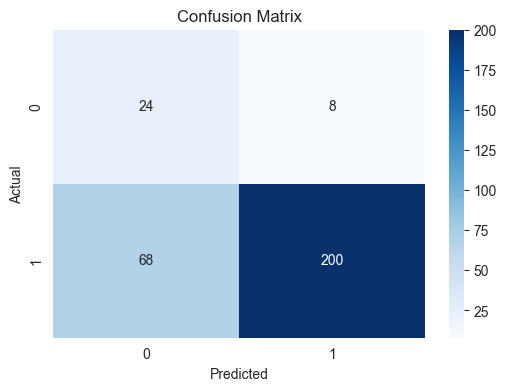

F1-Score: 0.8403


In [108]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")

### 15. Correlation with Target Variable (repayment_issue)

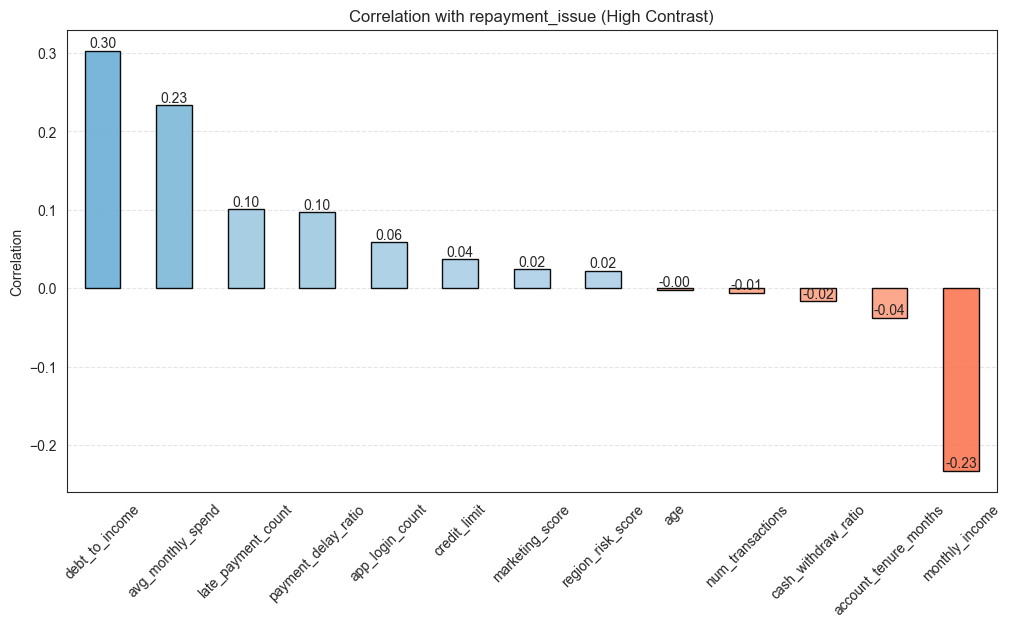

In [109]:
df["repayment_issue"] = df["repayment_issue"].astype(int)

numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col != "repayment_issue"]

corr = df[numeric_cols + ["repayment_issue"]].corr()["repayment_issue"].sort_values(ascending=False)
corr_drop = corr.drop("repayment_issue")

colors = []
for val in corr_drop:
    intensity = 0.3 + 0.6 * abs(val)
    if val >= 0:
        colors.append(plt.cm.Blues(intensity))
    else:
        colors.append(plt.cm.Reds(intensity))

plt.figure(figsize=(12,6))
bars = corr_drop.plot(
    kind="bar",
    color=colors,
    edgecolor="black",
    alpha=0.95
)

plt.title("Correlation with repayment_issue (High Contrast)")
plt.ylabel("Correlation")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)

for bar, val in zip(bars.patches, corr_drop):
    bars.annotate(f"{val:.2f}", 
                  xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', va='bottom', fontsize=10)

plt.show()